# Overview for Voronoi Plotting Notebook

This is notebook for making voronoi plots. The basic settings are all up top, after the imports. The plot itself is at the very bottom, if you want to tweak further.

Author: Zachary Hafen (zachary.h.hafen@gmail.com)

# Imports and Notebook Preferences

### Notebook Preferences

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Standard Imports

In [2]:
import numpy as np
from scipy.spatial import Voronoi

### Plotting Imports

In [3]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.use('PDF')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import pu_colormaps as pu_cm
# import matplotlib.transforms as transforms
# import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import general_plotting as gen_plot

### Default Changes to matplotlib

In [4]:
# Make the x and y ticks bigger
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2

# Notebook Settings

### Data Selection

In [5]:
# Random data for demonstration purposes. Replace this with the data you actually want.
# Make sure it's in the format of numpy arrays.

x_data = np.random.rand(15)
y_data = np.random.rand(15)
color_data = np.random.uniform(-500., -300., 15)

### Choose Parameters of the Plots

In [6]:
# These are the minimum and maximum values for the colorbar
min_color_value = color_data.min()
max_color_value = color_data.max()

# Choose the colormap you use. I've included two default recommendations.
used_cmap = cm.viridis
# used_cmap = cm.RdBu

# Plot points on top?
plot_points = True

### Miscellanious Settings

In [7]:
# Choose where to save the data
save_filename = './voronoi_plot.png'

# Construct the Voronoi Regions

In [8]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """    
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    
    Credit: http://stackoverflow.com/a/20678647

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [9]:
# Normalize the color data to map onto a colormap
normed_colors = np.interp(color_data, [min_color_value, max_color_value], [0., 1.])

In [10]:
# Compute Voronoi Tesselation

#  Put the x-data and y-data in a necessary format
points = np.array([x_data, y_data]).transpose()
vor = Voronoi(points)

# Get the regions and vertices.
regions, vertices = voronoi_finite_polygons_2d(vor)

## Make the Plot Itself

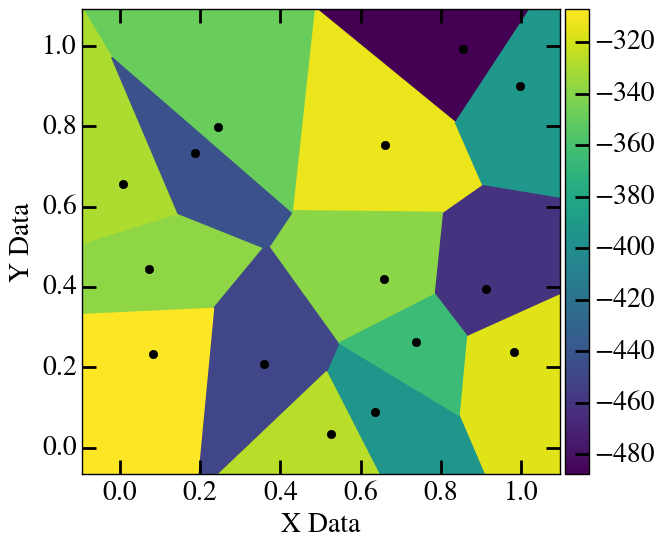

In [11]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

# colorize
for i, region in enumerate(regions):
    polygon = vertices[region]
    ax.fill(*zip(*polygon), color=used_cmap(normed_colors[i]))

# Make a scatter plot to add colors. This won't actually be seen, it's just needed to get the colorbar correct.
color_object = ax.scatter(x_data, y_data, c=color_data, cmap=used_cmap, \
                          vmin=min_color_value, vmax=max_color_value)

# Create divider for existing axes instance                                                                                                                                  
divider = make_axes_locatable(ax)

# Append axes to the right of ax, with 5% width of ax                                                                                                                       
cax = divider.append_axes("right", pad=0.05, size='5%')
# Create colorbar in the appended axes                                                                                                    
cbar = plt.colorbar(color_object, cax=cax,)                                                                                                          

if plot_points:
  ax.plot(x_data, y_data, 'ko')
  
# TWEAK THE PLOT
# Axes ratio
ax.axis('equal')
# Axes limits
ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
ax.set_ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)
# Axes labels
ax.set_xlabel('X Data', fontsize=20)
ax.set_ylabel('Y Data', fontsize=20)

In [12]:
# Save the file
fig.savefig(save_filename, dpi=300, bbox_inches='tight')